# Download Data

### Use Google Drive to store the weights from Mask RCNN

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Remove any previous contents in the colab directory

In [3]:
! rm -rf json/ labels/ images/ dataset.zip sample_data train_data/ val_data/ test_data/

### Download the image annotations from DeepGIS.

You can generate dataset by clicking the Deep Learning Zoo/Mask RCNN option (left side) of DeepGIS. This will create generate a link similar to 
https://project_name.deepgis.org/media/labels/harish/iKRvgHFmrWuDHppM/dataset.zip

Example shown here is that of LROC NAC image dataset, you can replace the dataset.zip with your annotations in DeepGIS

In [4]:
! wget https://fish.deepgis.org/media/labels/harish/zuKIvQfohhTLkMSm/dataset.zip

--2021-04-02 00:44:58--  https://fish.deepgis.org/media/labels/harish/zuKIvQfohhTLkMSm/dataset.zip
Resolving fish.deepgis.org (fish.deepgis.org)... 129.219.113.11
Connecting to fish.deepgis.org (fish.deepgis.org)|129.219.113.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45375907 (43M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  43.27M  51.5MB/s    in 0.8s    

2021-04-02 00:44:59 (51.5 MB/s) - ‘dataset.zip’ saved [45375907/45375907]



### Unzip the dataset.zip file. 
There will be two folders json/ and images/

In [5]:
! unzip -qq dataset.zip

# Import libraries

### Convert DeepGIS json annotations to numpy masks

In [6]:
! pip install wand
! apt-get install libmagickwand-dev -y -q

     |████████████████████████████████| 143kB 7.6MB/s 
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gir1.2-freedesktop
  gir1.2-gdkpixbuf-2.0 gir1.2-rsvg-2.0 gsfonts imagemagick-6-common
  libcairo-script-interpreter2 libcairo2-dev libcupsfilters1 libcupsimage2
  libdjvulibre-dev libdjvulibre-text libdjvulibre21 libgdk-pixbuf2.0-dev
  libgs9 libgs9-common libijs-0.35 libjbig2dec0 liblcms2-dev liblqr-1-0
  liblqr-1-0-dev libmagickcore-6-arch-config libmagickcore-6-headers
  libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra libmagickcore-6.q16-dev
  libmagickwand-6-headers libmagickwand-6.q16-3 libmagickwand-6.q16-dev
  libpixman-1-dev librsvg2-dev libwmf-dev libwmf0.2-7 libxcb-shm0-dev
  poppler-data
Suggested packages:
  fonts-noto ghostscript-x libcairo2-doc inkscape libjxr-tools librsvg2-doc
  libwmf-doc libwmf0.2-7-gtk poppler-utils fonts-japan

In [7]:
import os
import json
import re
import numpy as np
from wand.image import Image as WandImage
from wand.color import Color as WandColor
import io
import imageio
from bs4 import BeautifulSoup
import torch
from PIL import Image
import pickle
import cv2

In [8]:
def image_string_to_SVG_string_file(svgStr):
    SVG_string_file = io.StringIO(svgStr)
    SVG_string_file.seek(0)
    return SVG_string_file.read().encode('utf-8')

def image_label_string_to_SVG_string(DBStr, height=None, width=None, x=0, y=0, keepImage=False):
    addedStr = DBStr
    #get the image path
    imagePath = ""
    imageString = ""
    if keepImage:
        imagePath = re.search('ns1:href="(.*)png"', DBStr)
        try:
            imagePath = imagePath.group(1)+"png"
        except AttributeError as e:
            imagePath = re.search('a0:href="(.*)png"', DBStr)
            imagePath = imagePath.group(1) + "png"

        imageWidth = re.search(r'width="(\d+)"', addedStr).group(1)
        imageHeight = re.search(r'height="(\d+)"', addedStr).group(1)

        imageString = '<defs><pattern id="backgroundImage" ' \
        'patternUnits="userSpaceOnUse" width="%s" height="%s">' \
        '<image xlink:href="%s" x="-%s" y="-%s" width="%s" height="%s"/>' \
        '</pattern></defs><rect id="background" fill="url(#backgroundImage)" '\
        'width="%s" height="%s"/>' % (width, height, imagePath, x, y, imageWidth, imageHeight, width, height)

    if height == None or width == None:
        image, height, width = SVGDimensions(DBStr)
        if not keepImage and image:
            addedStr = DBStr.replace(image, '')

    addedStr = re.sub(r'<image.+hidden"/>', '', addedStr)
    addedStr = addedStr.encode('utf-8')
    return '<?xml version="1.0" encoding="UTF-8" standalone="no"?>' \
           '<svg version="1.1" id="Layer_1" xmlns="http://www.w3.org/2000/svg"' \
           ' xmlns:xlink="http://www.w3.org/1999/xlink" x="0px" y="0px" xml:space="preserve" height="%s"' \
           ' width="%s">%s%s</svg>' % (height, width, imageString, addedStr)


In [9]:
! rm -rf labels

In [10]:
IMAGE_FILE_EXTENSION = ".png"

CATEGORY_NAMES = None

json_files = os.listdir('json/')

if not os.path.exists('labels/'):
    os.makedirs('labels/')

for json_file in json_files:
  with open('json/' + json_file) as f:
    data = json.load(f)
  
  outputFilenameNpy = 'labels/' + json_file[:-4] + 'npz'
  height = data["height"]
  width = data["width"]
  ctr = 0
  total_paths = 1000
  masks_ndarray = np.zeros((total_paths, height, width), dtype=np.int8)

  CATEGORY_NAMES = data["categories"]

  for id, element in data["labelShapes"]:
    category_id = id
    svg = element
    paths = []
    poly = []
    soup = BeautifulSoup(svg)
    circles = soup.find_all('circle')
    poly = soup.find_all('polygon')
    paths = soup.find_all('path')
    ellipse = soup.find_all('ellipse')
    shapes = paths + poly + circles + ellipse

    if len(paths) + len(poly) + len(circles) + len(ellipse) > 0:
      for idx,path in enumerate(shapes):
        img=WandImage(blob=image_string_to_SVG_string_file(image_label_string_to_SVG_string(str(path),height,width)))
        img.resize(width, height)
        img.background_color = WandColor('white')
        img.alpha_channel = 'remove'
        img.negate()
        img.threshold(0)
        img.format = 'png'

        outputFilename = ('labels/' + json_file[:-4] + 'png')

        img.save(filename=outputFilename)
        im = imageio.imread(outputFilename)

        masks = np.array(im)
        cat_mask = np.where(masks == 255, category_id , masks)

        if cat_mask.max() != 0:
          cat_mask_check = cat_mask > 0
          cat_mask_check = cat_mask_check.astype(np.uint8)
          pos = np.where(cat_mask_check)
          xmin = np.min(pos[1])
          xmax = np.max(pos[1])
          ymin = np.min(pos[0])
          ymax = np.max(pos[0])
          if xmin < xmax and ymin < ymax:
            masks_ndarray[ctr, :, :] = cat_mask
            ctr = ctr + 1
          else:
            print("failed")
            # print(ctr)
  print(outputFilenameNpy)

  if ctr == 0:
    masks_ndarray[0, :, :] = np.zeros((height, width))
    print("NO MASKS FOUND") # Atleast one annotation needed for training
    ctr = 1

  
  print(ctr)
  masks_ndarray.resize(ctr, height, width)
  masks_ndarray = masks_ndarray.transpose(1, 2, 0)

  np.savez_compressed(outputFilenameNpy, mask=masks_ndarray)

  for rmfile in os.listdir('labels/'):
      if rmfile.endswith('.png'):
          os.remove('labels/' + rmfile)    

labels/_static_fish_Alvin5008_down__12_12_2018_19-54-02_0_48012.npz
NO MASKS FOUND
1
labels/_static_fish_Alvin5008_down__12_12_2018_19-54-02_0_08.npz
3
labels/_static_Alvin5006-downlooking-processed-selects_Alvin5006_down__12_10_2018_213230_0_058.npz
NO MASKS FOUND
1
labels/_static_Alvin5008_downlooking_processed_selects_Alvin5007_down__12_11_2018_21-02-23_0_061.npz
NO MASKS FOUND
1
labels/_static_Alvin5008-downlooking-processed-selects_Alvin5008_down__12_12_2018_18-33-02_0_063.npz
78
labels/_static_fish_Alvin5008_down__12_12_2018_21-21-42_0_05.npz
NO MASKS FOUND
1
labels/_static_Alvin5006-downlooking-processed-selects_Alvin5006_down__12_10_2018_162849_0_057.npz
23
labels/_static_fish_Alvin5008_down__12_12_2018_18-05-42_0_04.npz
2
labels/_static_fish_Alvin5008_down__12_12_2018_21-27-52_0_48010.npz
7
labels/_static_Alvin5006-downlooking-processed-selects_Alvin5006_down__12_10_2018_154659_0_48060.npz
NO MASKS FOUND
1
labels/_static_fish_Alvin5008_down__12_12_2018_18-33-02_0_016.npz
82
la

Display all the categories

In [11]:
print(CATEGORY_NAMES)

['background', 'crab', 'fish', 'tubeworm', 'other', 'anemones', 'shrimp', 'Tubeworm tubes']


### Import libraries for plotting the numpy masks

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg
import os
import numpy as np
import random

### Select a file and plot the masks


In [13]:
mask_files = os.listdir('labels/')
print(len(mask_files))
index = 2
mask_file = 'labels/' + mask_files[index]

63


Opening mask file labels/_static_fish_Alvin5008_down__12_12_2018_19-12-22_0_03.npz


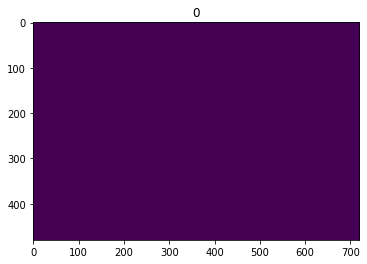

In [14]:
print("Opening mask file " + mask_file)

mask = np.load(mask_file)
mask = mask['mask']
for i in range(mask.shape[2]):
  plt.figure()
  plt.imshow(mask[:, :,i])
  plt.title(str(i))
  break

(480, 720, 1)


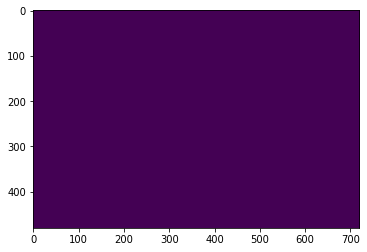

In [15]:
mask = np.load(mask_file)['mask']

print(mask.shape)

image = mask[:, :, 0]
plt.imshow(image)
plt.imsave('name.png', image)

### Overlay one of the image annotation on top of the image to validate the annotations

Image file is images/_static_fish_Alvin5008_down__12_12_2018_19-12-22_0_03.png


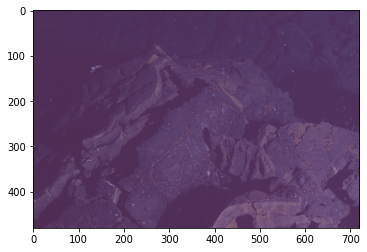

In [16]:
img = Image.open("name.png").convert("RGBA")
corresponding_image_file = "images/"  + mask_files[index].split(".")[0] + ".png"
print("Image file is " + corresponding_image_file)
background = Image.open(corresponding_image_file).convert("RGBA")

background.putalpha(150)
background.paste(img, (0, 0), background)
background.save('superimpose.png',"PNG")
img = mpimg.imread('superimpose.png')
imgplot = plt.imshow(img)

### Import libraries

In [17]:
! wget https://raw.githubusercontent.com/pytorch/vision/master/references/detection/engine.py 
! wget https://raw.githubusercontent.com/multimodallearning/pytorch-mask-rcnn/master/visualize.py
! wget https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_eval.py
! wget https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_utils.py
! wget https://raw.githubusercontent.com/pytorch/vision/master/references/detection/transforms.py
! wget https://raw.githubusercontent.com/pytorch/vision/master/references/detection/utils.py

--2021-04-02 00:46:37--  https://raw.githubusercontent.com/pytorch/vision/master/references/detection/engine.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3699 (3.6K) [text/plain]
Saving to: ‘engine.py’

engine.py           100%[===================>]   3.61K  --.-KB/s    in 0s      

2021-04-02 00:46:37 (67.0 MB/s) - ‘engine.py’ saved [3699/3699]

--2021-04-02 00:46:37--  https://raw.githubusercontent.com/multimodallearning/pytorch-mask-rcnn/master/visualize.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17335 (17K) [text

In [18]:
from engine import train_one_epoch, evaluate
import torch
from PIL import Image
import pickle
import cv2
import torch.nn as nn
import torchvision
import numpy as np
import os
import random
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from visualize import display_instances

# Mask RCNN Dataset

In [19]:
class Dataset(object):
    def __init__(self, image_path, label_path, transforms=None, savePickle=True, readsave=True, include_name=True):
        self.image_path = image_path
        self.label_path = label_path
        self.transforms = transforms
        self.images = [f for f in os.listdir(image_path) if f.endswith(".png")]
        self.masks = [f for f in os.listdir(label_path) if f.endswith(".npz")]
        self.include_name = include_name
        self.savePickle = savePickle
        self.__refine(readsave) 


    def __refine(self, readsave):
        if not readsave:
            images = []
            masks = []
            for img in self.images:
                frame = img[:-4]
                mask = frame + ".npz"
                if mask in self.masks:
                  images.append(img)
                  masks.append(mask)

            self.images = images
            self.masks = masks
            data = {"images": images, "masks": masks,}
            if self.savePickle:
                with open('data.pickle', 'wb') as filehandle:
                    pickle.dump(data, filehandle)
        else:
            with open('data.pickle', 'rb') as filehandle:
                data = pickle.load(filehandle)
                self.images = data["images"]
                self.masks = data["masks"]
    
    def __getitem(self, idx):
        img_path = os.path.join(self.image_path, self.images[idx])
        mask_path = os.path.join(self.label_path, self.masks[idx])

        image = Image.open(img_path).convert("RGB")
        # In training, 0 is of background
        masks = np.load(mask_path)['mask']
        # masks = masks > 0  # convert to binary masks
        masks = masks.astype(np.uint8)
        num_objs = masks.shape[2]
        labels = []
        for i in range(num_objs):
          labels.append(masks[:,:, i].max())
        obj_ids = np.array(labels)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[:, :, i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            # assert xmax > xmin, f"xmax {xmax} > xmin {xmin} failed for image id {idx}"
            # assert ymax > ymin, f"ymax {ymax} > ymin {ymin} failed for image id {idx}"
            # assert xmax >= 0 and xmax <= masks.shape[0], f"xmax {xmax} >= 0 and xmax <= {masks.shape[0]} failed for image id {idx}"
            # assert ymax >= 0 and ymax <= masks.shape[1], f"ymax {ymax} >= 0 and ymax <= {masks.shape[1]} failed for image id {idx}"
            # assert ymin >= 0 and ymin <= masks.shape[1], f"ymin {ymin} >= 0 and ymin <= {masks.shape[1]} failed for image id {idx}"
            # assert xmin >= 0 and xmin <= masks.shape[0], f"xmin {xmin} >= 0 and xmin <= {masks.shape[0]} failed for image id {idx}"
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(obj_ids, dtype=torch.int64)
        
        masks = masks > 0  # convert to binary masks
        masks = masks.astype(np.uint8)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        masks = masks.permute((2, 0, 1))

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        
        keep = (boxes[:, 3] > boxes[:, 1]) & (boxes[:, 2] > boxes[:, 0])
        boxes = boxes[keep]
        labels = labels[keep]
        masks = masks[keep]
        area = area[keep]
        iscrowd = iscrowd[keep]
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.include_name:
            target["image_name"] = img_path

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target

    def __getitem__(self, idx):
        return self.__getitem(idx)

    def __len__(self):
        return len(self.masks)

    def display(self, idx):
        image, target = self.__getitem__(idx)
        #image = image.permute((1, 2, 0))
        #image = (image.numpy() * 255).astype(np.uint8)
        #image = Image.fromarray(image)
        image.show()

        masks = target["masks"]
        masks = masks.permute((1, 2, 0))
        masks = masks.numpy()
        masks = masks.max(axis=2) * 255
        masks = Image.fromarray(masks)
        masks.show()

    def imageStat(self, percentage=0.01):
        images = np.empty((0, 3), float)
        # sample 10 % of the dataset and calculate mean etc (too long in Colab)
        sample = random.sample(self.images, int(len(self.images)*percentage))
        for data_file in sample:
            data_path = os.path.join(self.image_path, data_file)
            data = cv2.imread(data_path)
            image = data.astype(float).reshape(-1, 3)/255.0
            images = np.append(images, image, axis=0)
        return np.mean(images, axis=0).tolist(), np.std(images, axis=0).tolist(), \
               np.max(images, axis=0).tolist(), np.min(images, axis=0).tolist()

### Define transform code

In [20]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ToTensor(object):
    def __call__(self, image, target):
        image = np.array(image)
        image = torch.from_numpy(image / 255.0).float()
        image = image.permute((2, 0, 1))
        return image, target

def get_transform(train):
    transforms = []
    transforms.append(ToTensor()) 
    return Compose(transforms)

def get_mean_std(input_channel, image_mean, image_std):
    if input_channel == 8:
        return image_mean, image_std
    elif input_channel == 3:
        return image_mean[:3], image_std[:3]
    elif input_channel == 5:
        return image_mean[:5], image_std[:5]
    elif input_channel == 6:
        return image_mean[:3] + image_mean[-3:], image_std[:3] + image_mean[-3:]
    elif input_channel == 4:
        return image_mean[:3] + [np.mean(image_mean[-3:]).tolist()], image_std[:3] + [np.mean(image_std[-3:]).tolist()]
    elif input_channel == 'dem':
        return image_mean[-3:], image_std[-3:]

def collate_fn(batch):
    return tuple(zip(*batch))

In [21]:
def get_model_instance_segmentation(num_classes, image_mean, image_std, stats=False):
    # load an instance segmentation model pre-trained pre-trained on COCO
    #model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # the size shape and the aspect_ratios shape should be the same as the shape in the loaded model
    anchor_generator = AnchorGenerator(sizes=((32,), (64,), (128,), (256,), (512,)),
                                       aspect_ratios=((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)))
    model.rpn.anchor_generator = anchor_generator

    if stats:
        model.transform.image_mean = image_mean
        model.transform.image_std = image_std
    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    model.roi_heads.detections_per_img = 256

    return model

# Train Network

#### Split Dataset into train, validation and test

train 60% 

val 20%

test 20%

In [22]:
! mkdir -p train_data/images train_data/labels test_data/images test_data/labels val_data/images val_data/labels

In [23]:
from math import floor
import random
random.seed(42)


mask_files = os.listdir('labels/')
random.shuffle(mask_files)

split_index = int(floor(len(mask_files)*0.6))

train_data = mask_files[:split_index]
test_val_data = mask_files[split_index:]

split_index = int(floor(len(test_val_data)*0.5))

val_data = test_val_data[:split_index]
test_data = test_val_data[split_index:]

for file_name in train_data:
  jpg_file = file_name.split('.')[0] + ".png"
  os.system(f"rsync -avhW labels/{file_name} train_data/labels/")
  os.system(f"rsync -avhW images/{jpg_file} train_data/images/")

for file_name in test_data:
  jpg_file = file_name.split('.')[0] + ".png"
  os.system(f"rsync -avhW labels/{file_name} test_data/labels/")
  os.system(f"rsync -avhW images/{jpg_file} test_data/images/")

for file_name in val_data:
  jpg_file = file_name.split('.')[0] + ".png"
  os.system(f"rsync -avhW labels/{file_name} val_data/labels/")
  os.system(f"rsync -avhW images/{jpg_file} val_data/images/")

In [24]:
def validate_images_and_masks(images_directory="images", masks_directory="labels", remove=True):
    """
    Check if all the masks are in correct format, remove incorrect ones.
    Validate if the mask has a corresponding image in images folder.
    Removes all the non png files in images_directory and non npz files in masks_directory

    :param images_directory: folder containing images
    :param masks_directory: folder containing masks
    :type remove: bool

    """

    images = []
    for f in os.listdir(images_directory):
        if f.endswith(".png"):
            images.append(f)
        else:
            os.remove(os.path.join(images_directory, f))

    masks = []
    for f in os.listdir(masks_directory):
        if f.endswith(".npz"):
            masks.append(f)
        else:
            os.remove(os.path.join(masks_directory, f))

    images_ = []
    masks_ = []

    for img in images:
        frame = img[:-4]
        mask = frame + ".npz"
        if mask in masks:
            mask_path = os.path.join(masks_directory, mask)
            mask_d = np.load(mask_path)
            mask_nd = mask_d['mask']
            # print(mask_nd.shape, mask_path)
            if np.all(mask_nd.reshape((-1, mask_nd.shape[2])).max(axis=0)):
                images_.append(img)
                masks_.append(mask)
            else:
                print(f"{mask_path} is invalid.")
                if remove:
                    print(f"removing {mask_path} mask and {img} image")
                    os.remove(os.path.join(images_directory, img))
                    os.remove(os.path.join(masks_directory, mask))
        else:
            print(f"{images_directory}/{img}'s  mask is missing, removing this image file")
            if remove:
                print(f"removing {images_directory}/{img}")
                os.remove(os.path.join(images_directory, img))

### Data augmentation
The colab provides a fixed 75GB disk space and hence results in no disk space if you use data augmentation. We move the files to Google Drive (make sure you have enough space in Google Drive) and do the data augmentations. 

Avoid this, if you think the dataset is large enough

Enhance the image quality ( sharpness, contrast, saturation)

In [25]:
skip = False
if not skip:
  from PIL import Image, ImageEnhance, ImageOps

  files = os.listdir('./train_data/images/')
  
  for f in files:
    if ".png" in f[-4:]:
      im = Image.open('./train_data/images/' + f)
      file_name = f.split('.')[0]
      
      im_output = ImageOps.flip(im)
      im_output.save('./train_data/images/' + f'hflip-{file_name}.png')
      label = np.load(f'./train_data/labels/{file_name}.npz')['mask']
      new_label = np.flip(label, 0)
      np.savez_compressed(f'./train_data/labels/hflip-{file_name}.npz', mask=new_label)

      im_output = ImageOps.mirror(im)
      im_output.save('./train_data/images/' + f'vflip-{file_name}.png')
      label = np.load(f'./train_data/labels/{file_name}.npz')['mask']
      new_label = np.flip(label, 1)
      np.savez_compressed(f'./train_data/labels/vflip-{file_name}.npz', mask=new_label)

      enhancer = ImageEnhance.Contrast(im)

      factor = 0.5  # decrease constrast
      im_output = enhancer.enhance(factor)
      im_output.save('./train_data/images/' + f'less-contrast-{file_name}.png')
      os.system(f'cp ./train_data/labels/{file_name}.npz ./train_data/labels/less-contrast-{file_name}.npz')

      factor = 1.5  # increase contrast
      im_output = enhancer.enhance(factor)
      im_output.save('./train_data/images/' + f'more-contrast-{file_name}.png')
      os.system(f'cp ./train_data/labels/{file_name}.npz ./train_data/labels/more-contrast-{file_name}.npz')

      # image sharpness enhancer
      enhancer = ImageEnhance.Sharpness(im)

      factor = 0.05
      im_s_1 = enhancer.enhance(factor)
      im_s_1.save('./train_data/images/' + f'blurred-{file_name}.png')
      os.system(f'cp ./train_data/labels/{file_name}.npz ./train_data/labels/blurred-{file_name}.npz')

      factor = 2
      im_s_1 = enhancer.enhance(factor)
      im_s_1.save('./train_data/images/' + f'sharpened-{file_name}.png')
      os.system(f'cp ./train_data/labels/{file_name}.npz ./train_data/labels/sharpened-{file_name}.npz')

      # image brightness enhancer
      enhancer = ImageEnhance.Brightness(im)

      factor = 0.5  # darkens the image
      im_output = enhancer.enhance(factor)
      im_output.save('./train_data/images/' + f'darkened-{file_name}.png')
      os.system(f'cp ./train_data/labels/{file_name}.npz ./train_data/labels/darkened-{file_name}.npz')

      factor = 1.25  # brightens the image
      im_output = enhancer.enhance(factor)
      im_output.save('./train_data/images/' + f'brightened-{file_name}.png')
      os.system(f'cp ./train_data/labels/{file_name}.npz ./train_data/labels/brightened-{file_name}.npz')


## Validate Images and labels

In [26]:
validate_images_and_masks("train_data/images", "train_data/labels", True)
validate_images_and_masks("val_data/images", "val_data/labels", True)
validate_images_and_masks("test_data/images", "test_data/labels", True)

train_data/labels/brightened-_static_fish_Alvin5008_down__12_12_2018_20-32-52_720_031.npz is invalid.
removing train_data/labels/brightened-_static_fish_Alvin5008_down__12_12_2018_20-32-52_720_031.npz mask and brightened-_static_fish_Alvin5008_down__12_12_2018_20-32-52_720_031.png image
train_data/labels/more-contrast-_static_fish_Alvin5008_down__12_12_2018_19-54-02_0_48012.npz is invalid.
removing train_data/labels/more-contrast-_static_fish_Alvin5008_down__12_12_2018_19-54-02_0_48012.npz mask and more-contrast-_static_fish_Alvin5008_down__12_12_2018_19-54-02_0_48012.png image
train_data/labels/blurred-_static_fish_Alvin5008_down__12_12_2018_21-21-42_720_020.npz is invalid.
removing train_data/labels/blurred-_static_fish_Alvin5008_down__12_12_2018_21-21-42_720_020.npz mask and blurred-_static_fish_Alvin5008_down__12_12_2018_21-21-42_720_020.png image
train_data/labels/vflip-_static_fish_Alvin5008_down__12_12_2018_19-12-22_0_48014.npz is invalid.
removing train_data/labels/vflip-_stati

### Load device

In [27]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)  # make sure you have cuda for training


cuda


### Load data

In [28]:
train_dataset = Dataset("./train_data/images/", "./train_data/labels/", transforms=get_transform(train=True), readsave=False, include_name=False)
val_dataset = Dataset("./val_data/images/", "./val_data/labels/", transforms=get_transform(train=True), readsave=False, include_name=False)
test_dataset = Dataset("./test_data/images/", "./test_data/labels/", transforms=get_transform(train=False), readsave=False, savePickle=False, include_name=True)



image_mean, image_std, _, _ = train_dataset.imageStat(0.5)  # get mean and std if you don't know
print(image_mean)
print(image_std)

data_loader_train = torch.utils.data.DataLoader(
    train_dataset, batch_size=1, shuffle=True, num_workers=8,
    collate_fn=collate_fn)


data_loader_val = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, shuffle=True, num_workers=8,
    collate_fn=collate_fn)


data_loader_test = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

[0.22045209652903075, 0.22282344333413684, 0.19929292692202605]
[0.1997720994351819, 0.20798700636048037, 0.21133153551940648]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Create a directory inside Google Drive to save the checkpoints

In [28]:
foldername = "trained_param_fish_v1_jan26"
#can change folder name here to save it in new folder, use ctrlF to change folder name everywhere

In [29]:
# Create trained_param_fish_v1 folder in google drive
! mkdir /content/drive/My\ Drive/trained_param_fish_v1_jan26
#can change file name to change file without rewriting old one, make sure to change all places that says this

### Train Mask RCNN

In [30]:
# get the model using our helper function
mask_rcnn = get_model_instance_segmentation(len(CATEGORY_NAMES), image_mean, image_std, stats=True)

# get weights from previous models
read_param = False
if read_param:
    mask_rcnn.load_state_dict(torch.load("/content/drive/My Drive/trained_param_fish_v1_jan26/epoch_0010.param"))
    #This is where I change epoch choice
    print("Loaded weights")

# move model to the right device
mask_rcnn.to(device)

# construct an optimizer
params = [p for p in mask_rcnn.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)
init_epoch = 0
num_epochs = 12

#'''
for epoch in range(init_epoch, init_epoch + num_epochs):
    save_param = "/content/drive/My Drive/trained_param_fish_v1_jan26/epoch_{:04d}.param".format(epoch)
    torch.save(mask_rcnn.state_dict(), save_param)
    
    # train for one epoch, printing every 10 iterations
    train_one_epoch(mask_rcnn, optimizer, data_loader_train, device, epoch, print_freq=100)
    
    # update the learning rate
    lr_scheduler.step()
    
    # if (epoch+1) % 5 == 0:
    evaluate(mask_rcnn, data_loader_val, device=device)

    print(save_param)

    print("-------------------------------------------------------------------------------\n\n")

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [  0/234]  eta: 0:05:07  lr: 0.000026  loss: 3.0571 (3.0571)  loss_classifier: 1.5894 (1.5894)  loss_box_reg: 0.0036 (0.0036)  loss_mask: 1.4026 (1.4026)  loss_objectness: 0.0595 (0.0595)  loss_rpn_box_reg: 0.0020 (0.0020)  time: 1.3143  data: 0.3638  max mem: 1312
Epoch: [0]  [100/234]  eta: 0:01:08  lr: 0.002170  loss: 1.1967 (1.9095)  loss_classifier: 0.4510 (0.6394)  loss_box_reg: 0.3124 (0.3964)  loss_mask: 0.3355 (0.5379)  loss_objectness: 0.0512 (0.2710)  loss_rpn_box_reg: 0.0163 (0.0648)  time: 0.4424  data: 0.0753  max mem: 3461
Epoch: [0]  [200/234]  eta: 0:00:15  lr: 0.004314  loss: 0.4994 (1.5194)  loss_classifier: 0.1371 (0.4923)  loss_box_reg: 0.1519 (0.3615)  loss_mask: 0.2728 (0.4164)  loss_objectness: 0.0604 (0.1933)  loss_rpn_box_reg: 0.0034 (0.0558)  time: 0.3302  data: 0.0042  max mem: 3461
Epoch: [0]  [233/234]  eta: 0:00:00  lr: 0.005000  loss: 0.4778 (1.4290)  loss_classifier: 0.0867 (0.4598)  loss_box_reg: 0.0840 (0.3381)  loss_mask: 0.2437 (0.3971) 

# Inference

In [44]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)  # check your device

cuda


In [45]:
def visualize_pred(image, pred):
    """
    visualize only one prediction
    :param pred:
    :return:
    """
    if image.shape[0] > 3:
        image = image[:3, :, :]
    boxes_ = pred["boxes"].cpu().detach().numpy().astype(int)
    boxes = np.empty_like(boxes_)
    boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3] = boxes_[:, 1], boxes_[:, 0], boxes_[:, 3], boxes_[:, 2]
    labels = pred["labels"].cpu().detach().numpy()
    scores = pred["scores"].cpu().detach().numpy()
    masks = pred["masks"]
    indices = scores > 0.5
    boxes = boxes[indices]
    labels = labels[indices]
    scores = scores[indices]
    print(labels)
    masks = masks[indices].squeeze(1)
    masks = (masks.permute((1, 2, 0)).cpu().detach().numpy() > 0.5).astype(np.uint8)
    image = image.permute((1, 2, 0)).cpu().detach().numpy()*255
    return display_instances(image, boxes, masks, labels, class_names=CATEGORY_NAMES, scores=scores)

def visualize_gt(image, target):
    if image.shape[0] == 3:
        image = image.permute((1, 2, 0)).cpu().detach().numpy() * 255
    else:
        image = image[:3, :, :].permute((1, 2, 0)).cpu().detach().numpy() * 255

    boxes_ = target["boxes"].cpu().detach().numpy().astype(int)
    boxes = np.empty_like(boxes_)
    boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3] = boxes_[:, 1], boxes_[:, 0], boxes_[:, 3], boxes_[:, 2]
    masks = target["masks"].permute((1, 2, 0)).cpu().detach().numpy()
    labels = target["labels"].cpu().detach().numpy()
    return display_instances(image, boxes, masks, labels, class_names=CATEGORY_NAMES)

def visualize_result(model, data):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    image, target = data
    visualize_gt(image, target)
    pred = model(image.unsqueeze(0).to(device))
    visualize_pred(image, pred[0])


In [46]:
# assert model path
model_path = "/content/drive/My Drive/trained_param_fish_v1_jan26/epoch_0010.param"  # this should be the path where you save your training model
assert os.path.exists(model_path)

In [47]:
mask_rcnn = get_model_instance_segmentation(len(CATEGORY_NAMES), image_mean, image_std, stats=True)
mask_rcnn.to(device)
mask_rcnn.eval()
mask_rcnn.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [48]:
%matplotlib inline

# Metrics for MaskRCNN


1.   **Average Precision** across IoU from 0.5 to 0.95 at 0.05 intervals are calculated for each species. 

2.   **Average Recall** is the area under the curve from Recall vs IoU plots
3.   **Mean average Precision** is mean of the average precision from all categories

---

Example:
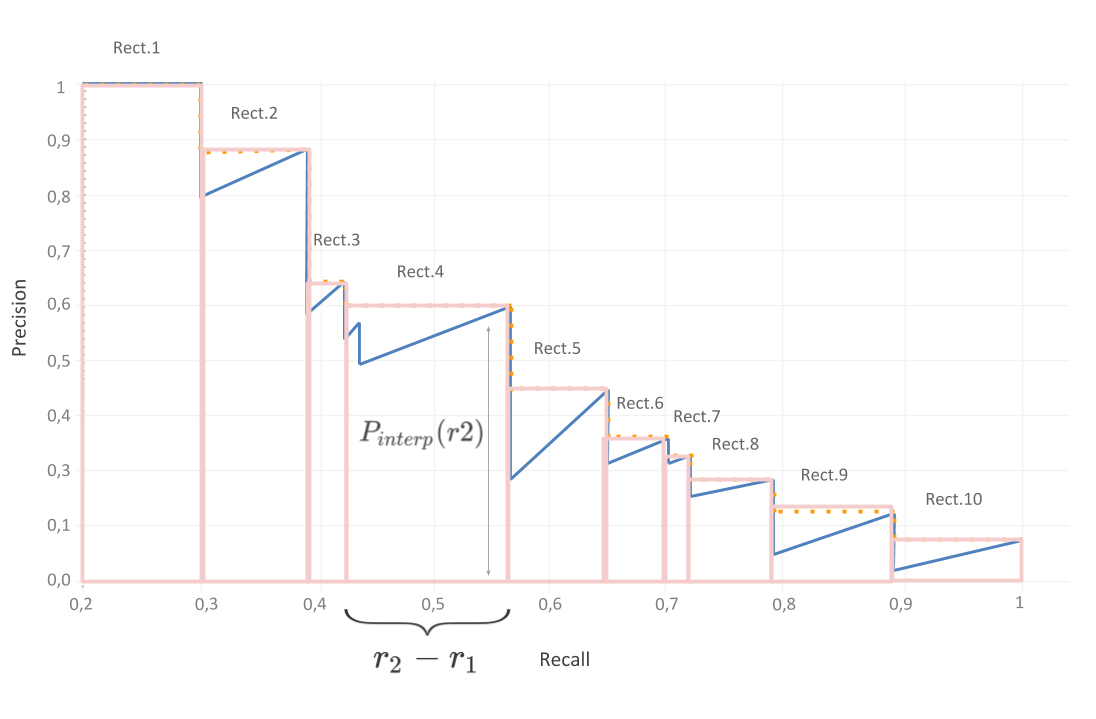

AP=∑​(R(n)​−R(n−1​))* precision​(R(n​))

In our case, R(n)​−R(n−1​) is always equal to 0.01 and 
AP=∑​(0.01)* precision​(R(n​))

mean AP = ∑​APi / N, where i represent each category

AR=2 * Integral from 0.5 to 1​ recall(IoU)dIoU

**Details**

`Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.135`

1. IoU=0.50:0.95 means you are averaging the IoU from 0.5 to 0.95 at 0.05 intervals. So, the IoU would be `[0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]`

Lets say we set IoU threshold to 0.5, then we consider true positives to be detection with IoU > 0.5.


2. `area=   all`,
 pixel area 

```
all = [0, 10000000000.0], 
small = [0, 1024]
medium = [1024, 9216]
large = [9216, 10000000000.0]
```

3. maxDets=100 (Maximum Detections)
```
number of craters selected from sorted list (ascending order of confidence) : [1, 10, 100]
```

Steps to follow:
1. GT data, and predictions
2. Set IoU to 0.5 (IoU > 0.5 TP, IoU <= 0.5 FP) 
3. precision = TP/ all predictions, recall = TP/ all your annotations 
3. Compare GT data and predictions and get a list of all true positive predictions
4. Sort all prediction by confidence scores. 
5. Precision is TP / (TP + FP)
6. Recall is TP / (TP + FN)


Assume that 11 is the number of GT crater in image 1. Here we show the top 4 predictions from image 1. The number of prediction does not equal the number of GT craters.
```
crater, confidence, TP, FP, cummulative TP, cumulative FP, precision,   recall
C1,           0.98, TP,  -,              1,             0,   1/(1+0),    1 / 11
C2,           0.95, TP,  -,              2,             0,   2/(2+0),    2 / 11
C3,           0.93,  -, FP,              2,             1,   2/(2+1),    2 / 11
C4,            0.7,  -, FP,              2,             2,   2/(2+2),    2 / 11
..
..
..
..                                                                       11 / 11
```



In [49]:
e = evaluate(mask_rcnn, data_loader_test, device=device)

creating index...
index created!


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test:  [0/5]  eta: 0:00:04  model_time: 0.3748 (0.3748)  evaluator_time: 0.1490 (0.1490)  time: 0.9182  data: 0.3926  max mem: 3744
Test:  [4/5]  eta: 0:00:00  model_time: 0.1221 (0.1820)  evaluator_time: 0.0068 (0.0435)  time: 0.3081  data: 0.0805  max mem: 3744
Test: Total time: 0:00:01 (0.3205 s / it)
Averaged stats: model_time: 0.1221 (0.1820)  evaluator_time: 0.0068 (0.0435)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.317
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.520
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.369
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.331
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.289
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall   

**Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.732**

Read it as,

Average precision calculated from top 100 detections in the test dataset, with changing IoU threshold from 0.5 to 0.95 at 0.05 threshold.

In [50]:
T = e.coco_eval['segm'].eval['params'].iouThrs
print("T IoU threshold: \n", T)
R = e.coco_eval['segm'].eval['params'].recThrs
print("R recall threshold: \n", R)
K = e.coco_eval['segm'].eval['params'].catIds
print("K cat ids: \n", K)
A = e.coco_eval['segm'].eval['params'].areaRng
print("A area range: \n", A)
M = e.coco_eval['segm'].eval['params'].maxDets
print("M max detection cases: \n", M)

T IoU threshold: 
 [0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]
R recall threshold: 
 [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]
K cat ids: 
 [1, 3, 7]
A area range: 
 [[0, 10000000000.0], [0, 1024], [1024, 9216], [9216, 10000000000.0]]
M max detection cases: 
 [1, 10, 100]


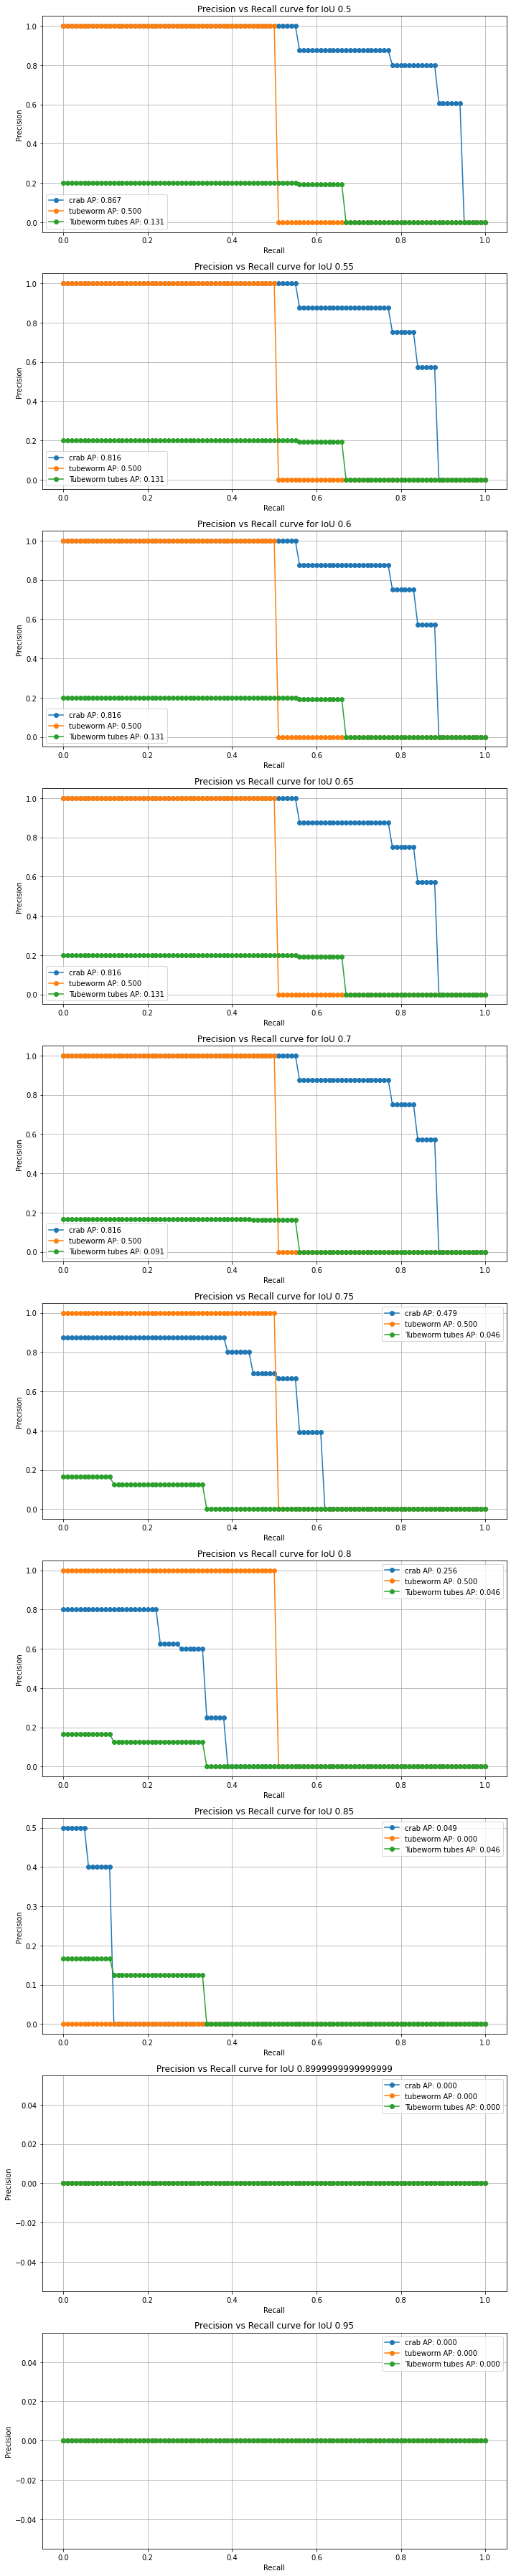

In [51]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,50)

sampling_interval = 1
IoU = 5
fig, ax = plt.subplots(10)

for cat in range(len(K)):
  for i in range(0, 10): # from 0.5-0.95 plotted
    IoU = T[i]
    x = e.coco_eval['segm'].eval['params'].recThrs[::sampling_interval]
    y = e.coco_eval['segm'].eval['precision'][i, :, cat, 0, 2][::sampling_interval]
    ap = sum(0.01*y[1:])
    ax[i].plot(x,y, marker='o', label=f'{CATEGORY_NAMES[K[cat]]} AP: {ap:.3f}')
    ax[i].set_xlabel('Recall')
    ax[i].set_ylabel('Precision')
    ax[i].set_title(f'Precision vs Recall curve for IoU {IoU}')
    ax[i].legend()
    ax[i].grid(True)

fig.tight_layout()
plt.show()

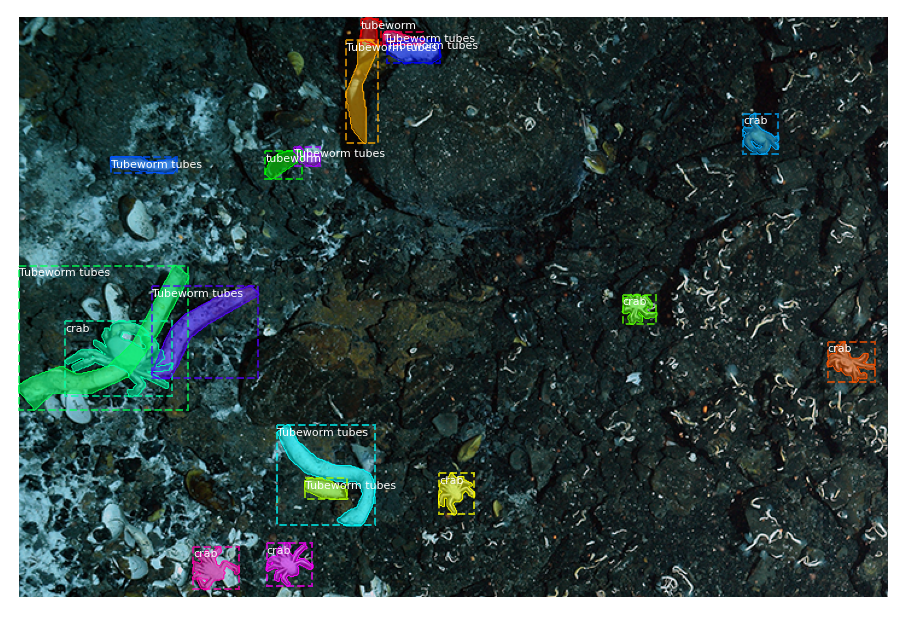

[1 1 1 1 7 2 3 1 1 4 4 4 7 1 7 2]


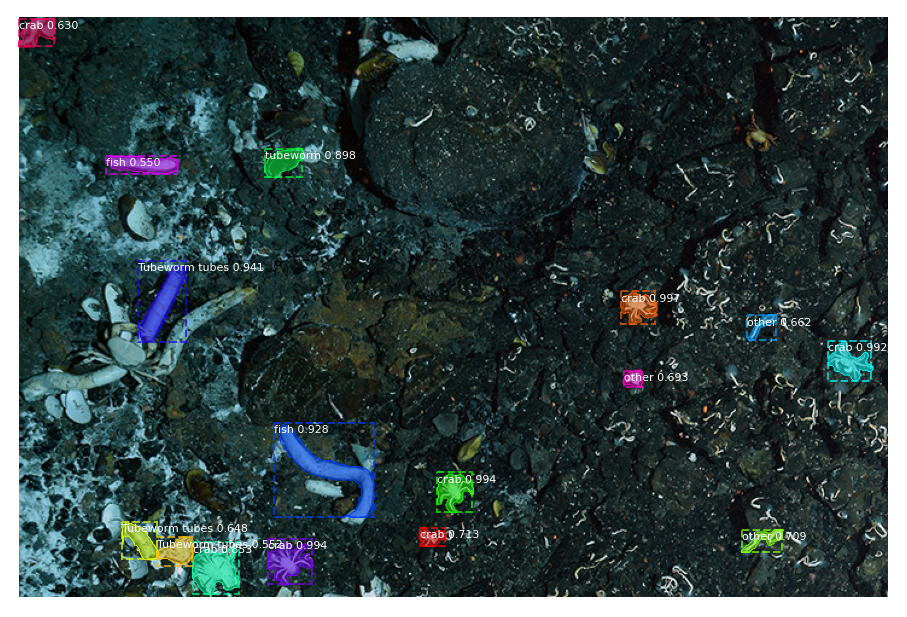

In [52]:
count = 0
for i, data in enumerate(test_dataset):
    image, target = data
    pred = mask_rcnn(image.unsqueeze(0).to(device))[0]

    boxes = pred['boxes'].to("cpu").detach().numpy()
    labels = pred['labels'].to("cpu").detach().numpy()
    scores = pred['scores'].to("cpu").detach().numpy()
    masks = pred['masks'].to("cpu").detach().numpy()  # the predictions, numpy ndarray
    indices = scores > 0.5
    labels = labels[indices]

    if np.unique(labels).shape[0] > 0:
      visualize_result(mask_rcnn, data)
      count += 1
    
    break # only one result shown